# Dynamic Epidemiological Modeling with Hamiltonian Monte-Carlo

## Introduction

In this notebook, we propose a practical application of Hamiltonian Monte-Carlo (HMC) to dynamic modeling of epidemiological data in the context of the COVID-19 pandemic. In this work, a dynamic $SE_MI_KR$ (Susceptible-Exposed-Infectious-Remove) mechanistic compartmental model is used. Compartmental models work by splitting the population into disjoint compartments and defining a transition flow between compartments; whereas mechanistic modeling refers to situations where the disease dynamics are purely governed by differential equations. Moreover, a time-dependent transmission rate $\beta(t)$ (i.e,. the average number of contacts per person, per time unit, multiplied by the probability of infection in a contact) parametrized by Bayesian B-splines is used.

The $SE_MI_KR$ model consists of the following compartments:

* $S$ corresponds to the number of individuals that are **susceptible** to be infected.
* $E_1, \ldots, E_M$ reflect the number of individuals at different stages of **exposure** (i.e., infected but not yet infectious). The average time spent by an individual being exposed is $\frac{1}{\alpha}$.
* $I_1, \ldots, I_K$ reflect the number of **infectious** individuals. The average time spent by an individual being infectious is $\frac{1}{\gamma}$.
* $R$ represents the number of individuals \textbf{removed} from the pool of susceptible individuals (either by death or by recovery).
* $C_I$ is a **counter** of the total number of individuals that have been infected.
* $\beta(t)$ is the time-dependent transmission rate.

To model the transmission rate $\beta(t)$ a set of B-splines is used such that:
\begin{equation}
    \log \beta(t) = \sum_{i=1}^m \beta_i B_i(t)
\end{equation}
where $\lbrace B_i (t) \rbrace_{i=1}^m$ form a B-spline basis over the time interval $[t_0, t_1]$, with $m=q+d-1$ ($q$ is the number of knots, $d$ is the degree of the polynomials of the B-splines); and $\bm{\beta}=(\beta_1, \ldots, \beta_m)$ is a vector of coefficients.

Likewise, the model is governed by the following system of ODEs:
\begin{align}
    \dot{S}(t) &= -\beta(t)S(t)\dfrac{I(t)}{N},\\
    \dot{E}_1 (t) &= \beta(t)S(t)\dfrac{I(t)}{N}-M\alpha E_1(t), \qquad \dot{E}_M(t) = M\alpha E_{M-1}(t) - M\alpha E_M(t),\\
    \dot{I}_1 (t) &= M\alpha E_M (t) - K\gamma I_1 (t), \qquad \dot{I}_K (t) = K \gamma I_{K-1}(t) - K\gamma I_K (t),\\
    \dot{R}(t)&=K\gamma I_K (t),\\
    \dot{C}_I (t) &= \beta(t)S(t)\dfrac{I(t)}{N}
\end{align}
with the following constraints:
\begin{equation}
    \begin{cases}
        S(t_0) = N - E_0\\
        E_1(t_0)=C_I (t_0) = E_0\\
        E_2(t_0)=\cdots=E_M(t_0)=0\\
        I_1(t_0)=\cdots=I_K(t_0)0\\
        R(t_0)=0\\
        E(t) = \sum_{i=1}^M E_i(t)\\
        I(t) = \sum_{j=1}^K I_j(t)\\
        N = S(t) + E(t) + I(t) + R(t)
    \end{cases}
\end{equation}
Note that the number of newly infected individuals at time $t$ is given by $\beta(t)S(t)I(t)/N$.

Additionally, the total number of new individuals infected at day $t$ is given by: 
\begin{equation}
    C(t) = C_I(t) - C_I(t-1)
\end{equation}

Where our *predicted* (corrected) daily incidence are sampled from the following distribution:
\begin{equation}
    \dfrac{\tilde{C}(t)}{\eta(t)} \sim \operatorname{Neg.Binom.}(C(t), \phi)
\end{equation}

To simplify the notation, we will use the following notations to represent the **state** $\bm{y}(t)$ and **parameters** $\bm{p}$ of our model respectively:
\begin{align}
    \bm{y}(t)&=\left[S(t), E_1(t), \ldots, E_M(t), I_1, \ldots, I_K(t), R(t), C_I(t)\right]^T\\
    \bm{p} &= \left[\alpha, \gamma, E_0, \phi^{-1}, \tau, \bm{\beta}\right]^T
\end{align}

## Loading the Daily Incidence Data from the Basque Country

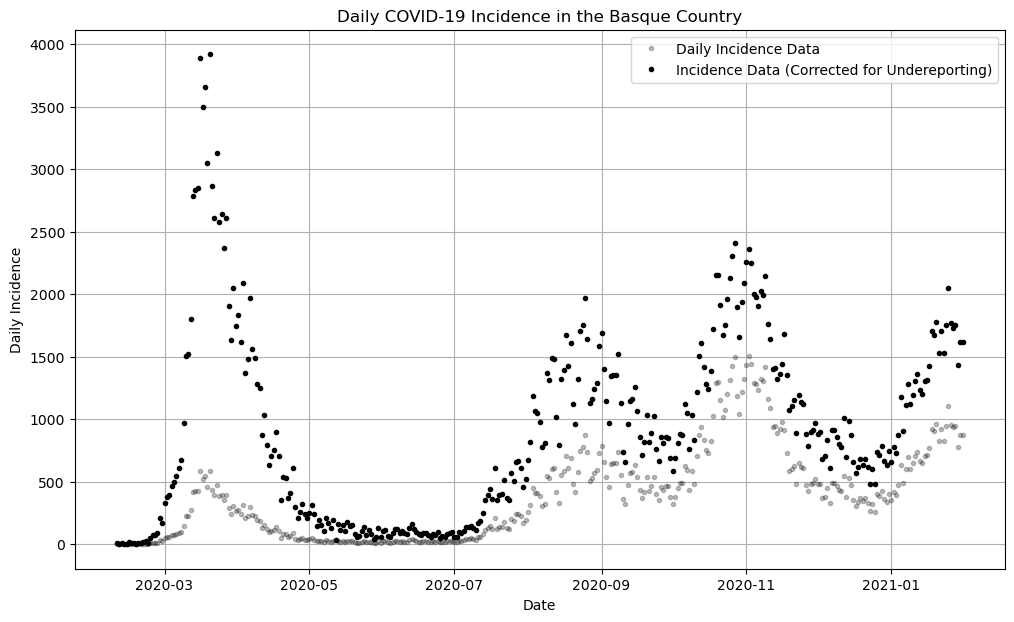

In [60]:
import os, sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

def corrected_incidence_data(original_data):
    """
    Correct the incidence data for underreporting.
    The data is corrected by dividing the incidence data by the underreporting factor for each day.
    """
    corrected_data = np.copy(original_data)
    corrected_data[:92] /= 0.15
    corrected_data[93:281] /= (0.15 + (0.54 - 0.15)*(np.arange(93, 281) - 92)/(231 - 92))
    corrected_data[281:] /= 0.54
    return corrected_data

def plot_incidence_curve(original_data, corrected_data, dates, save = False):
    plt.figure(figsize = (12, 7))
    plt.plot(dates, original_data, 'o', label = 'Daily Incidence Data', color = 'black', markersize = 3, alpha = 0.25)
    plt.plot(dates, corrected_data, 'o', label = 'Incidence Data (Corrected for Undereporting)', color = 'black', markersize = 3)
    plt.legend()
    plt.title("Daily COVID-19 Incidence in the Basque Country")
    plt.xlabel('Date')
    plt.ylabel('Daily Incidence')
    plt.legend()
    plt.grid()
    if save: plt.savefig('Daily_Incidence_Curve_Basque.pdf')
    plt.show()

filePath = filePath = os.path.join(os.path.dirname("__file__"), f"../pyHaiCS/benchmarks/Epidemiological/Basque_Country_covid19_SIR_data.txt")
original_data, population_size = np.loadtxt(filePath)[:-1], int(np.loadtxt(filePath)[-1]) # Last instance is the total population
corrected_data = corrected_incidence_data(original_data)
# Initial date: 10th of February 2020. Last date: 31st of January 2021
initial_date, last_date = np.datetime64('2020-02-10'), np.datetime64('2021-01-31')
dates = np.arange(initial_date, last_date + 1, dtype='datetime64[D]')
plot_incidence_curve(original_data, corrected_data, dates)

Note that the data is corrected for under-reporting by linear interpolation of the seroprevalence in the Basque Country. In this case:
\begin{equation}
\eta(t) = 
\begin{cases} 
0.15 & \text{if } 0 < t \leq 92 \\
0.15 + \frac{0.54 - 0.15}{231 - 92} \cdot (t - 92) & \text{if } 92 < t < 281 \\
0.54 & \text{if } 281 \leq t
\end{cases}
\end{equation}

## Initalizing the Parameters and State of the $SE_MI_KR$ Model

In this section we initialize both the state and the parameters of our model according to the following priors:
\begin{align*}
\alpha &\sim \mathcal{N}(0.5, 0.05^2) \\
\gamma &\sim \text{TruncNormal}(0.1, 0.015^2, 1/30, 1) \\
E_0 &\sim \mathcal{N}(21.88, 7.29^2) \\
\phi^{-1} &\sim \text{Exponential}(10) \\
\tau &\sim \text{Inv.Gamma}(1, 0.005) \\
\beta_i &= -1.6 \quad \text{for } i = 1, \ldots, 15
\end{align*}

In [61]:
from scipy.stats import truncnorm

# Initialize the parameters of the SEIR Model
alpha = np.random.normal(0.5, 0.05) # Inverse of the average time being exposed
gamma_lower_trunc_bound, gamma_upper_trunc_bound = 1/30, 1
gamma_mu, gamma_sigma = 0.1, 0.015
# Inverse of the average time being infectious
gamma = truncnorm.rvs((gamma_lower_trunc_bound - gamma_mu) / gamma_sigma, 
                  (gamma_upper_trunc_bound - gamma_mu) / gamma_sigma, 
                  loc = gamma_mu, scale = gamma_sigma)
E0 = np.random.normal(21.88, 7.29) # Initial number of exposed individuals
# phi = np.random.exponential(10) # Dispersion parameter
phi = 0.005 # Dispersion parameter
beta = np.array([-1.6 for _ in range(15)]) # Spline coefficients
# Initial params of the SEIR model: alpha, gamma, E0, phi, beta
params = np.array([alpha, gamma, E0, phi, *beta])
print(f"Alpha: {alpha:.4f}, Gamma: {gamma:.4f}, E0: {E0:.4f}, Phi: {phi}")

Alpha: 0.4855, Gamma: 0.1107, E0: 16.1662, Phi: 0.005


The initial state of our model is given by:
\begin{equation}
    \bm{y}(t_0) = 
    \left[ S(t_0), E_1(t_0), \ldots, E_M(t_0), I_1(t_0), \ldots, I_K(t_0), R(t_0), C_I(t_0) \right]^T = \left[ N - E_0, E_0, \ldots, 0, 0, \ldots, 0, 0, E_0 \right]^T
\end{equation}


In [62]:
# Initial state of the SEIR model: S, E1, ..., EM, I1,..., IK, R, C
M, K = 1, 3 # We consider a SEI3R model (M = 1, K = 3)
E_init = np.array([E0] + [0 for _ in range(M - 1)])
I_init = np.array([0 for _ in range(K)])
state = np.concatenate([np.array([population_size - E0]), E_init, I_init, np.array([0, E0])])
print(f"Initial state: {state}")

Initial state: [2.18558883e+06 1.61661860e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.61661860e+01]


And we define the time-dependent transmission rate $\beta(t)$:

In [63]:
from scipy.interpolate import BSpline

# Define the spline basis functions for the time-dependent transmission rate (over time)
knots = np.linspace(0, 1, 12) # Q = 12 knots, d = 3
spline_basis = lambda t: np.exp(BSpline(knots, beta, k = 3)(t))

## Example of Direct Implementation (i.e., by Direct Solution of the ODE System)

In [64]:
from scipy.integrate import solve_ivp
from scipy.stats import nbinom

# We define the system of ODEs for the SEIR model
def SEMIKR_ODE(t, state, params, M, K, beta_t):
    """
    System of ODEs of the SEMIKR model.
    """
    # Unpack the state of the system (S, E1, ..., EM, I1,..., IK, R, C)
    S = state[0]
    E = state[1:M + 1]
    I = state[M + 1:M + K + 1]
    R = state[M + K + 1]
    C = state[M + K + 2]
    alpha, gamma = params[0], params[1]
    # Compute the derivatives of the system
    dSdt = -beta_t(t) * S * I.sum() / population_size
    dEdt = np.zeros(M)
    dEdt[0] = beta_t(t) * S * I.sum() / population_size - M * alpha * E[0]
    for m in range(1, M):
        dEdt[m] = M * alpha * E[m - 1] - M * alpha * E[m]
    dIdt = np.zeros(K)
    dIdt[0] = M * alpha * E[M - 1] - K * gamma * I[0]
    for k in range(1, K):
        dIdt[k] = K * gamma * I[k - 1] - K * gamma * I[k]
    dRdt = K * gamma * I.sum()
    dCdt = beta_t(t) * S * I.sum() / population_size
    return np.concatenate([[dSdt], dEdt, dIdt, [dRdt, dCdt]])

# Solve the ODE using the initial conditions and the spline basis functions
t_span = (0, len(corrected_data))
solution = solve_ivp(SEMIKR_ODE, t_span, state, args = (params, M, K, spline_basis), t_eval = np.arange(0, len(corrected_data), 1))
# Extract the solution of the ODE system
S, E, I, R, C_cumul = solution.y[0], solution.y[1:M + 1], solution.y[M + 1:M + K + 1], solution.y[M + K + 1], solution.y[M + K + 2]
# C contains the cumulative incidence data, so we need to compute the daily incidence
C_pred = np.zeros(len(C_cumul))
C_pred[0] = C_cumul[0]
C_pred[1:] = C_cumul[1:] - C_cumul[:-1]
# Now extract samples from a negative binomial distribution with n = predicted_daily_incidence, p = phi
predicted_daily_incidence = nbinom.rvs(C_pred, phi)

And we plot the results:

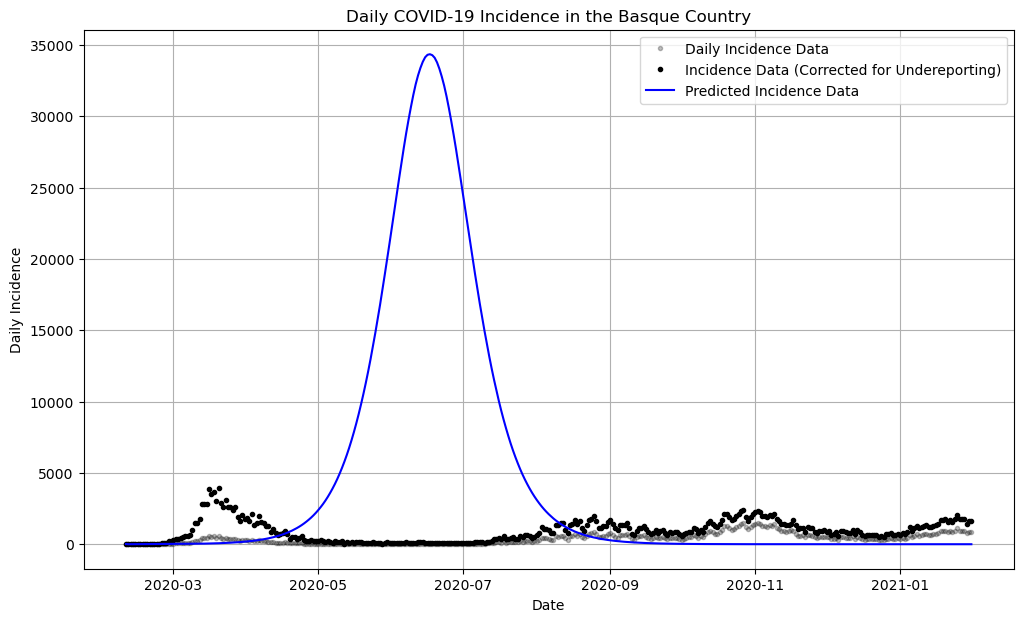

In [65]:
def plot_incidence_curve(original_data, corrected_data, predicted_data, dates, save = False):
    plt.figure(figsize = (12, 7))
    plt.plot(dates, original_data, 'o', label = 'Daily Incidence Data', color = 'black', markersize = 3, alpha = 0.25)
    plt.plot(dates, corrected_data, 'o', label = 'Incidence Data (Corrected for Undereporting)', color = 'black', markersize = 3)
    plt.plot(dates, predicted_data, label = 'Predicted Incidence Data', color = 'blue')
    plt.legend()
    plt.title("Daily COVID-19 Incidence in the Basque Country")
    plt.xlabel('Date')
    plt.ylabel('Daily Incidence')
    plt.legend()
    plt.grid()
    if save: plt.savefig('Daily_Incidence_Curve_Basque.pdf')
    plt.show()

plot_incidence_curve(original_data, corrected_data, C_pred, dates)

## Dynamic Implementation (w/HMC Sampling and Gradient Descent Opt. on the Parameters)

First we need to explicitly define our log-posterior of the parameters:

\begin{equation}
    \begin{aligned}
        \mathcal{L}(\bm{p})&=\mathcal{L}_{\text{like}}(\bm{p}) + \mathcal{L}_{\text{prior}}(\bm{p})\\
        &=\sum_{j=1}^n \mathcal{L}_{\text{like}}^j(\bm{p}) + \mathcal{L}_{\text{prior}}(\bm{p})\\
        &=\sum_{j=1}^n \left[\dfrac{\Gamma(\tilde{C}(t) + \phi)}{\Gamma(\phi)\Gamma(\tilde{C}(t) + 1)} \left(\dfrac{C(t)}{C(t)+\phi}\right)^{\tilde{C}(t)} \left(\dfrac{\phi}{C(t)+\phi}\right)^\phi\right] + \mathcal{L}_{\text{prior}}(\bm{p})
    \end{aligned}
\end{equation}
where $n$ is the number of instances in our observed data.

*Note that in order to alleviate the notation, we use $\tilde{C}(t)$ as short for the corrected daily incidence $\dfrac{\tilde{C}(t)}{\eta(t)}$*

In [70]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import truncnorm, norm, expon, nbinom

def potential_fn(data, state, params):
    """
    Potential function of the SEIR model.
    """
    # print(f"Log-prior: {log_prior(params)}, Log-likelihood: {log_likelihood(data, state, params)}")
    return -log_prior(params) - log_likelihood(data, state, params)

def potential_fn_grad(data, state, params):
    """
    Gradient of the potential function of the SEIR model.
    """
    # print(f"Log-prior grad: {log_prior_grad(params)}, Log-likelihood grad: {log_likelihood_grad(data, state, params)}")
    return -log_prior_grad(params) - log_likelihood_grad(data, state, params)

def log_prior(params):
    """
    Log-prior of the parameters of the SEIR model.
    """
    alpha, gamma, E0, phi, beta = params[0], params[1], params[2], params[3], params[4:]
    alpha_prior = norm.logpdf(alpha, 0.5, 0.05)
    gamma_prior = truncnorm.logpdf(gamma, (gamma_lower_trunc_bound - gamma_mu) / gamma_sigma, 
                  (gamma_upper_trunc_bound - gamma_mu) / gamma_sigma, 
                  loc = gamma_mu, scale = gamma_sigma)
    E0_prior = norm.logpdf(E0, 21.88, 7.29)
    phi_prior = expon.logpdf(1/phi, 10)
    beta_prior = norm.logpdf(beta, -1.6, 0.5).sum()
    # print(f"Alpha prior: {alpha_prior}, Gamma prior: {gamma_prior}, E0 prior: {E0_prior}, Phi prior: {phi_prior}, Beta prior: {beta_prior}")
    return alpha_prior + gamma_prior + E0_prior + phi_prior + beta_prior

def log_prior_grad(params):
    """
    Gradient of the log-prior of the parameters of the SEIR model.
    """
    alpha, gamma, E0, phi, beta = params[0], params[1], params[2], params[3], params[4:]
    alpha_grad = jax.grad(norm.logpdf)(alpha, 0.5, 0.05)
    gamma_grad = jax.grad(truncnorm.logpdf)(gamma, (gamma_lower_trunc_bound - gamma_mu) / gamma_sigma, 
                  (gamma_upper_trunc_bound - gamma_mu) / gamma_sigma, 
                  loc = gamma_mu, scale = gamma_sigma)
    E0_grad = jax.grad(norm.logpdf)(E0, 21.88, 7.29)
    phi_grad = jax.grad(expon.logpdf)(1/phi, 10)
    beta_grad = [jax.grad(norm.logpdf)(b, -1.6, 0.5) for b in beta]
    # print(f"Alpha grad: {alpha_grad}, Gamma grad: {gamma_grad}, E0 grad: {E0_grad}, Phi grad: {phi_grad}, Beta grad: {beta_grad}")
    return jnp.array([alpha_grad, gamma_grad, E0_grad, phi_grad, *beta_grad])

def extract_ode_solution(data, state, params, M, K, beta):
    """
    Extract the solution of the ODE system for the SEIR model.
    """
    t_span = (0, len(data))
    knots = jnp.linspace(0, 1, 12) # Q = 12 knots, d = 3
    spline_basis = lambda t: jnp.exp(BSpline(knots, beta, k = 3)(t))
    solution = solve_ivp(SEMIKR_ODE, t_span, state, args = (params, M, K, spline_basis), t_eval = jnp.arange(0, len(data), 1))
    # Extract the solution of the ODE system
    S, E, I, R, C_cumul = solution.y[0], solution.y[1:M + 1], solution.y[M + 1:M + K + 1], solution.y[M + K + 1], solution.y[M + K + 2]
    # C contains the cumulative incidence data, so we need to compute the daily incidence
    C_pred = jnp.zeros(len(C_cumul))
    C_pred = C_pred.at[0].set(C_cumul[0])
    C_pred = C_pred.at[1:].set(C_cumul[1:] - C_cumul[:-1])
    return C_pred

def log_likelihood_grad(data, state, params):
    """
    Gradient of the log-likelihood of the SEIR model.
    """
    alpha, gamma, E0, phi, beta = params[0], params[1], params[2], params[3], params[4:]
    # Extract the solution of the ODE system
    C_pred = extract_ode_solution(data, state, params, M, K, beta)
    # Compute the gradient of the log-likelihood of the negative binomial distribution
    log_likelihood_grads = jax.grad(lambda data, C_pred, phi: nbinom.logpmf(data, C_pred, phi).sum())(data, C_pred, phi)
    return log_likelihood_grads.sum()

def log_likelihood(data, state, params):
    """
    Log-likelihood of the SEIR model.
    """
    alpha, gamma, E0, phi, beta = params[0], params[1], params[2], params[3], params[4:]
    # Solve the ODE system using the initial parameters
    C_pred = extract_ode_solution(data, state, params, M, K, beta)
    # Compute the log-likelihood of the negative binomial distribution
    log_likelihoods = nbinom.logpmf(data, C_pred, phi)
    return log_likelihoods.sum()

We now apply gradient ascent to further optimize our initial selection of parameters: 

In [ ]:
from tqdm import tqdm

learning_rate, grad_steps = 1e-7, 10

# Step 1: Optimize the parameters of the SEIR model using the potential function
params_opt = params.copy()
for i in tqdm(range(grad_steps), desc = 'Optimizing Parameters w/ Gradient Ascent'):
    # Compute the gradient of the potential function
    grads = potential_fn_grad(corrected_data, state, params_opt)
    # Update the parameters using the gradient
    params_opt = params_opt + learning_rate * grads